# Effect of Job Title on Average Salaries of Data Science Professions

In [6]:
# Import Libraries
library(cowplot)
library(digest)
library(infer)
library(repr)
library(tidyverse)
library(RCurl)
library(broom)
library(dplyr)

## Introduction

With the rising importance of big data and the ability to process it, the data science industry can generate millions of dollars in revenue. As such, people who work in these positions have high salaries. However, "data science" encompasses many different professions, such as data scientists, data engineers, and data analysts. Despite working with similar tools and knowledge, different professions can have different salaries. Past studies have found that the job title sets an initial expectation for the value of the job itself and controlling for it could mediate the variation in salaries amongst industry professionals, suggesting that a small difference in a job title can affect its salary, even if the work done is similar to other titles (Smith et al., 1989; Gerhart, 1990). This leads to the question: Is there a significant difference among the average salaries of different data science job titles?

---

## Methods & Results

### Overview

Shapiro Wilk test was used first to check the Normality of the sample distributions. Next, pairwise F-test for equal variance was used to check if all three common data science job titles had the same variance at the adjusted significance level of approximately $\frac{0.05}{3}$ = 1.67%. One-way ANOVA was then used to test the null hypothesis of no difference among the mean average salaries of 3 common data science job titles (data scientist, data engineer, analyst) and the alternative hypothesis of at least one group's mean is different from the others' means at significance level of 5%. Tukey-Kramer test was then used for pairwise mean comparison upon the rejection of ANOVA's null hypothesis at the adjusted significance level of $\frac{0.05}{3}$ = 1.67%. Lastly, approximated 95% confidence intervals using both Central Limit Theorem and bootstrapping were constructed to derive a plausible range of mean average salaries for the 3 job titles. 

### Preliminary Exploratory Data Analysis

In [7]:
# load dataset from web
ds_df <- read_csv("https://raw.githubusercontent.com/erliuu/STAT-201-Group-48/main/datascience.csv")
names(ds_df) <- make.names(names(ds_df), unique=TRUE)

# Remove Job Description Column for visual purposes (due to length)
head(ds_df)[-c(4)]

Rows: 742 Columns: 42
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (17): Job Title, Salary Estimate, Job Description, Company Name, Locatio...
dbl (25): index, Rating, Founded, Hourly, Employer provided, Lower Salary, U...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


index Job.Title                 Salary.Estimate             Rating
1 0     Data Scientist            $53K-$91K (Glassdoor est.)  3.8   
2 1     Healthcare Data Scientist $63K-$112K (Glassdoor est.) 3.4   
3 2     Data Scientist            $80K-$90K (Glassdoor est.)  4.8   
4 3     Data Scientist            $56K-$97K (Glassdoor est.)  3.8   
5 4     Data Scientist            $86K-$143K (Glassdoor est.) 2.9   
6 5     Data Scientist            $71K-$119K (Glassdoor est.) 3.4   
  Company.Name                               Location        Headquarters  
1 Tecolote Research\n3.8                     Albuquerque, NM Goleta, CA    
2 University of Maryland Medical System\n3.4 Linthicum, MD   Baltimore, MD 
3 KnowBe4\n4.8                               Clearwater, FL  Clearwater, FL
4 PNNL\n3.8                                  Richland, WA    Richland, WA  
5 Affinity Solutions\n2.9                    New York, NY    New York, NY  
6 CyrusOne\n3.4                              Dallas, TX      Dallas, TX    
  Size        Founded Type.of.ownership  ⋯ tensor hadoop tableau bi flink mongo
1 501 - 1000  1973    Company - Private  ⋯ 0      0      1       1  0     0    
2 10000+      1984    Other Organization ⋯ 0      0      0       0  0     0    
3 501 - 1000  2010    Company - Private  ⋯ 0      0      0       0  0     0    
4 1001 - 5000 1965    Government         ⋯ 0      0      0       0  0     0    
5 51 - 200    1998    Company - Private  ⋯ 0      0      0       0  0     0    
6 201 - 500   2000    Company - Public   ⋯ 0      0      0       1  0     1    
  google_an job_title_sim  seniority_by_title Degree
1 0         data scientist na                 M     
2 0         data scientist na                 M     
3 0         data scientist na                 M     
4 0         data scientist na                 na    
5 0         data scientist na                 na    
6 0         data scientist na                 na

After reading the dataset, we only selected the variables of interest, the average salary (thousand USD) and the job title.

In [8]:
# Subset & Clean
trim_df <- ds_df %>%
    select(Avg.Salary.K., job_title_sim) %>%
    rename(Avg_Salary=Avg.Salary.K., Job_Title=job_title_sim) %>%
    filter(Job_Title != "na")
head(trim_df)

Avg_Salary Job_Title     
1  72.0      data scientist
2  87.5      data scientist
3  85.0      data scientist
4  76.5      data scientist
5 114.5      data scientist
6  95.0      data scientist

Next, we plotted the overall sample distribution and the sample distribution of each job title.

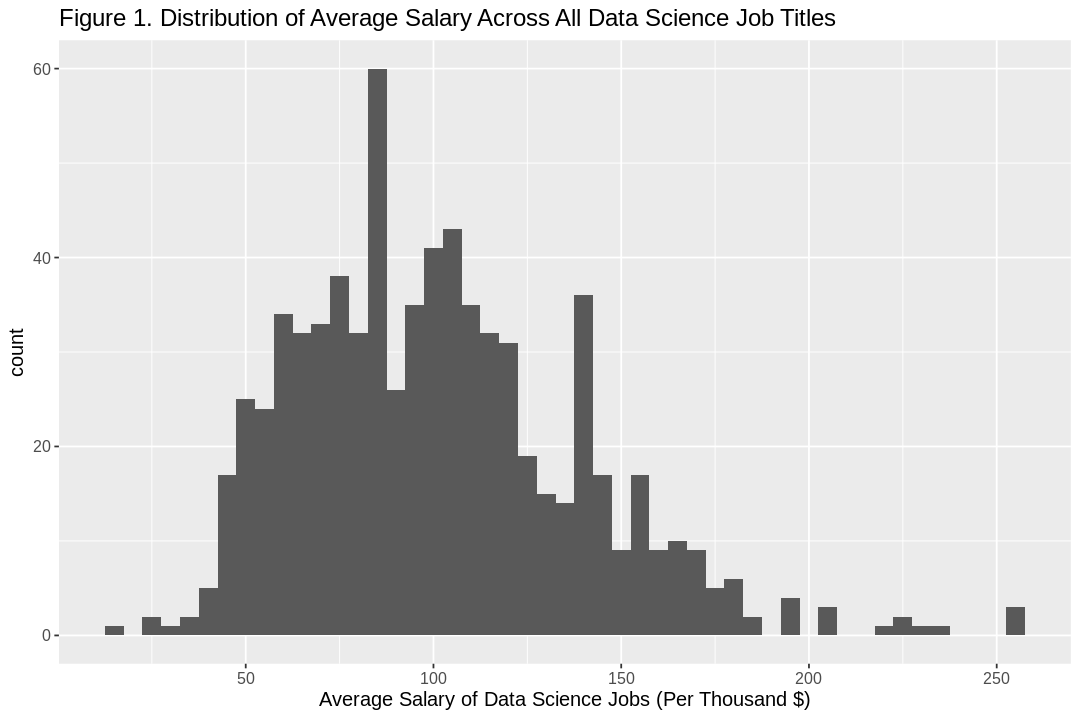

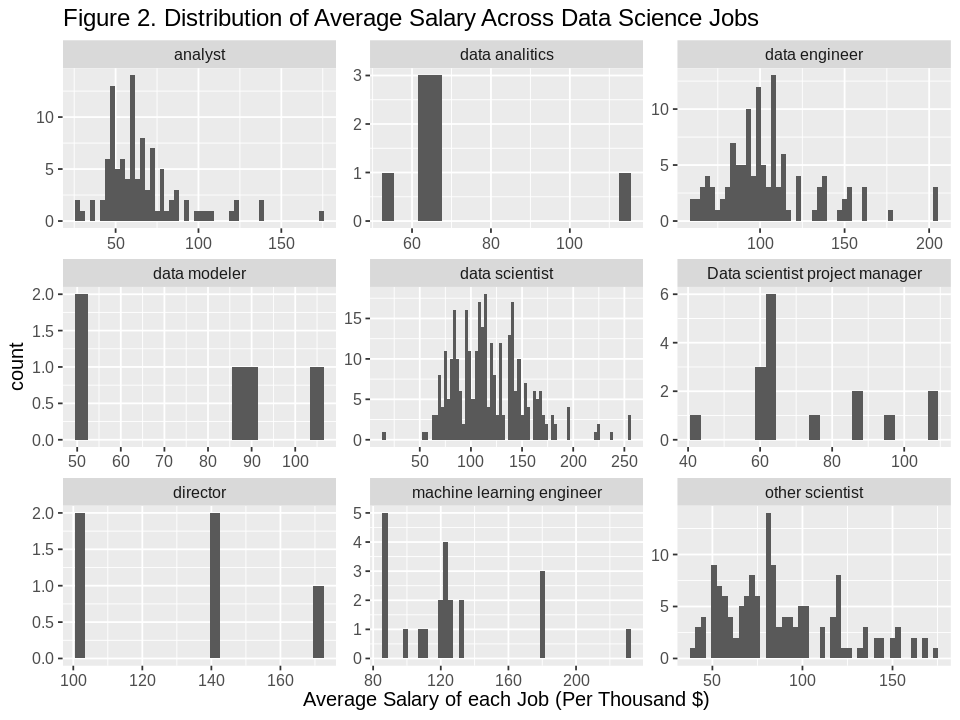

In [9]:
# Histogram of Average Salaries of ALL job titles
options(repr.plot.width=9, repr.plot.height=6)
ggplot(trim_df) +
    geom_histogram(aes(x = Avg_Salary), binwidth = 5) +
    xlab("Average Salary of Data Science Jobs (Per Thousand $)") +
    ggtitle("Figure 1. Distribution of Average Salary Across All Data Science Job Titles") + 
    theme(text = element_text(size=12))

# Plotting each Distribution
options(repr.plot.width=8, repr.plot.height=6)
p1 <- ggplot(trim_df) +
    geom_histogram(aes(x = Avg_Salary), binwidth = 3) +
    xlab("Average Salary of each Job (Per Thousand $)") +
    ggtitle("Figure 2. Distribution of Average Salary Across Data Science Jobs") + 
    facet_wrap(~Job_Title, scale="free") +
    theme(text = element_text(size=12))
plot(p1)

After assessing the distributions, we chose three common job titles in the industry in which their sample sizes were sufficiently large, in other words, at least 30 (Fig.2). While the job title "other scientist" did have more than 30 samples, it was too vague in our opinion and was thus eliminated. The chosen ones are:
1. `data scientist`
2. `analyst`
3. `data engineer`

The dataset was further trimmed down to only keep the data for the three chosen groups. A new figure containing just the three sample distributions and a boxplot version were made.

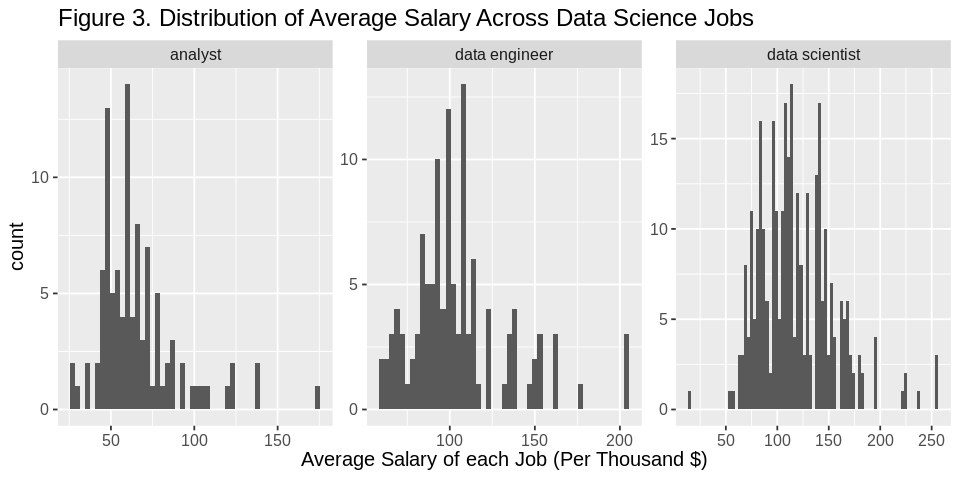

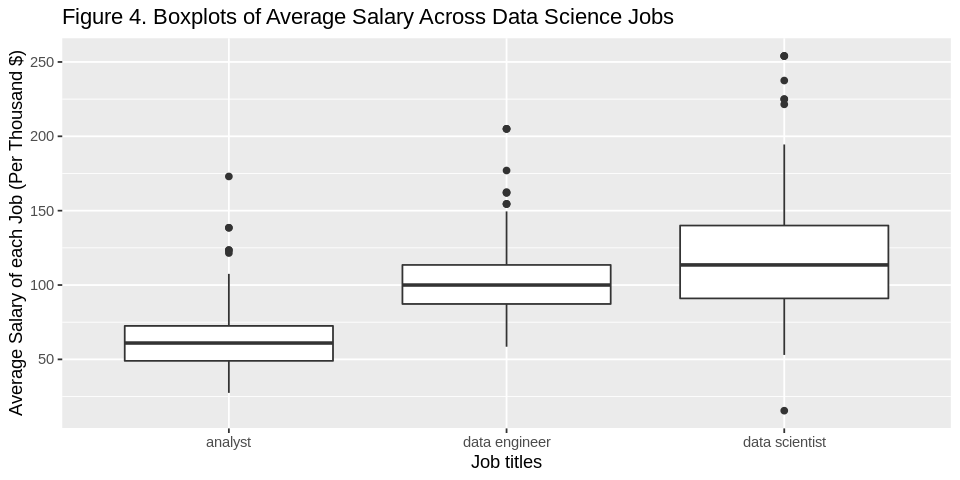

In [10]:
# Filter the dataset to only keep the necessary data
keep_jobs <- c('data scientist', 'analyst', 'data engineer')
subset_df <- trim_df %>%
    filter(Job_Title %in% keep_jobs)

# Plotting each Distribution
options(repr.plot.width=8, repr.plot.height=4)
p2 <- ggplot(subset_df) +
    geom_histogram(aes(x = Avg_Salary), binwidth = 3) +
    xlab("Average Salary of each Job (Per Thousand $)") +
    ggtitle("Figure 3. Distribution of Average Salary Across Data Science Jobs") + 
    facet_wrap(~Job_Title, scale="free") +
    theme(text = element_text(size=12))
plot(p2)

# Plotting a boxplot of sample distribution of different job title categories
p_box <- ggplot(subset_df, aes(x = Job_Title, y = Avg_Salary)) +
        geom_boxplot() + 
    labs(x = "Job titles", 
         y = "Average Salary of each Job (Per Thousand $)",
         title = "Figure 4. Boxplots of Average Salary Across Data Science Jobs") 
p_box

All three sample distributions show various degrees of right skew but none of them was very strong (Fig. 3). While the boxplot does show some potential outliers (Fig. 4), we assumed that those were jobs with average salaries that were not very common (too high or too low) but should still be considered as possible natural variations in the populations. Therefore, the outliers were not removed.

We then created a summary statistics table for the three groups.

In [6]:
# Putting the non-bootstrapped summary statistic estimates in a table:
prelim_summary_table <- subset_df %>%
    group_by(Job_Title) %>% 
    summarize(mean = mean(Avg_Salary),
              std_dev = sd(Avg_Salary),
              n=n())

##### Table 1. Summary statistics from preliminary exploratory data analysis

In [7]:
prelim_summary_table

Job_Title      mean      std_dev  n  
1 analyst         66.11386 24.32559 101
2 data engineer  105.40336 29.20415 119
3 data scientist 118.29393 35.86401 313

### Shapiro Wilk Test for Normality of Sample Distributions

One assumption of ANOVA is that all the samples are independent of each other and this was assumed for the samples in our dataset as you should not be able to tell the average salary of a job even when knowing other jobs' salaries. Another assumption of ANOVA is that the samples should come from Normally distributed populations. Here, we assessed the Normality of the sample distributions as they resemble their respective population distribution via Shapiro Wilk test. Specifically, for each level of the job title, we tested the following hypotheses at 5% significance level:
- $H_0$: there is no difference between the sample distribution and a Normal distribution
- $H_A$: there is a difference between the sample distribution and a Normal distribution

In [13]:
# separate the dataset into 3 groups by the job title
analyst_data <- subset_df %>% filter(Job_Title == "analyst")
engineer_data <- subset_df %>% filter(Job_Title == "data engineer")
scientist_data <- subset_df %>% filter(Job_Title == "data scientist")

In [14]:
# perform Shapiro Wilk test for Normality
analyst_shapiro <- shapiro.test(analyst_data$Avg_Salary) %>% 
    tidy()

engineer_shapiro <- shapiro.test(engineer_data$Avg_Salary) %>% 
    tidy()

scientist_shapiro <- shapiro.test(scientist_data$Avg_Salary) %>%
    tidy()

In [18]:
# create summary table for the 3 Shapiro Wilk tests
shapiro_summary_table <- tibble(Job_Title = c("data_scientist", "data_engineer", "analyst"),
                                test_statistic = c(analyst_shapiro$statistic,
                                                   engineer_shapiro$statistic,
                                                   scientist_shapiro$statistic),
                                p_value = c(analyst_shapiro$p.value,
                                            engineer_shapiro$p.value,
                                            scientist_shapiro$p.value))

##### Table 2. Summary table of Shapiro Wilk test results for normality of sample distributions 

In [19]:
shapiro_summary_table

Job_Title      test_statistic p_value     
1 data_scientist 0.8589621      2.286351e-08
2 data_engineer  0.9047669      3.805543e-07
3 analyst        0.9528623      1.749046e-08

The results show that all 3 sample distributions, which implies the population distributions as well, deviated from a Normal distribution since all 3 p-values were less than 0.05 (Table 2.) and our figures of the sample distributions did show some right skew (Fig. 3, 4). However, since the right skew was not very strong for all 3 sample and population distributions (Fig. 3, 4), and that all 3 groups had large sample sizes (Table 1.), given that when sample sizes are large, ANOVA is quite robust to slight deivations from Normality (Whitlock & Schluter, 2015), we decided that the Normality condition for ANOVA was met. 

### Pairwise Hypothesis Testing for Equal Variance Overview

Since the samples were not from exactly Normal populations, we attempted to use Levene's and Brown-Forsythe tests as both do not rely on the Normality assumption. However, due to technical difficulties, the required R packages could not be installed. Therefore, we proceeded with pairwise F-test to check the equal variance assumption required by ANOVA despite it being quite sensitive to non-Normality. Specifically, all possible pairs were tested at adjusted significance level of $\frac{0.05}{3}$= 1.67%.

In [20]:
# Preparations for F-tests

scientist_original_sample <- subset_df %>%
    filter(Job_Title == "data scientist")

#head(scientist_original_sample)

engineer_original_sample <- subset_df %>%
    filter(Job_Title == "data engineer")

#head(engineer_original_sample)

analyst_original_sample <- subset_df %>%
    filter(Job_Title == "analyst")

#head(analyst_original_sample)

#### Hypothesis Testing for Equal Variance with F-test - Part 1: data scientist vs data engineer

The first pair was data scientist and data engineer. We tested the following hypotheses:

- $H_0$: The variance of average salary is the same for both data scientist and data engineer

- $H_A$: The variance of average salary is different for both data scientist and data engineer

##### Table 3. F-test result for equal variance between data scientist and data engineer's average salaries

In [21]:
# F-test for equal variance between data scientist and data engineer
f_test_sci_engi <- tidy(var.test(x = scientist_original_sample$Avg_Salary, 
                                y = engineer_original_sample$Avg_Salary, 
                                ratio = 1, 
                                alternative = "two.sided",
                                conf.level = 1 - 0.05/3))

f_test_sci_engi

Multiple parameters; naming those columns num.df, den.df



estimate num.df den.df statistic p.value    conf.low conf.high
1 1.508094 312    118    1.508094  0.01003538 1.02996  2.148622 
  method                          alternative
1 F test to compare two variances two.sided

Based on the result, $H_0$ was rejected at the significance level of 1.67% (p-value = 0.0100), suggesting that data scientist and data engineer have different variances and standard deviations for their average salaries (Table 3.).

#### Hypothesis Testing for Equal Variance with F-test - Part 2: data scientist vs analyst

The second pair was data scientist and analyst. We tested the following hypotheses:

- $H_0$: The variance of average salary is the same for both data scientist and analyst

- $H_A$: The variance of average salary is different for both data scientist and analyst

##### Table 4. F-test result for equal variance between data scientist and analyst's average salaries

In [80]:
# F-test for equal variance between data scientist and analyst
f_test_sci_ana <- tidy(var.test(x = scientist_original_sample$Avg_Salary, 
                                y = analyst_original_sample$Avg_Salary, 
                                ratio = 1, 
                                alternative = "two.sided",
                                conf.level = 1 - 0.05/3))

f_test_sci_ana

Multiple parameters; naming those columns num.df, den.df



estimate num.df den.df statistic p.value      conf.low conf.high
1 2.173657 312    100    2.173657  1.024725e-05 1.444147 3.15822  
  method                          alternative
1 F test to compare two variances two.sided

Based on the result, $H_0$ was rejected at the significance level of 1.67% (p-value = 0.00001), suggesting that data scientist and analyst have different variances and standard deviations for their average salaries (Table 4.).

#### Hypothesis Testing for Equal Variance with F-test - Part 3: data engineer vs analyst

The third pair was data engineer and analyst. We tested the following hypotheses:

- $H_0$: The variance of average salary is the same for both data engineer and analyst

- $H_A$: The variance of average salary is different for both data engineer and analyst

##### Table 5. F-test result for equal variance between data engineer and analyst's average salaries

In [81]:
# F-test for equal variance between data engineer and analyst
f_test_engi_ana <- tidy(var.test(x = engineer_original_sample$Avg_Salary, 
                                 y = analyst_original_sample$Avg_Salary, 
                                 ratio = 1, 
                                 alternative = "two.sided",
                                 conf.level = 1 - 0.05/3))

f_test_engi_ana

Multiple parameters; naming those columns num.df, den.df



estimate num.df den.df statistic p.value    conf.low conf.high
1 1.441327 118    100    1.441327  0.06044558 0.903296 2.281616 
  method                          alternative
1 F test to compare two variances two.sided

Based on the result, $H_0$ was not rejected at the significance level of 1.67% (p-value = 0.0604), suggesting that data engineer and analyst have the same variance and standard deviation for their average salaries (Table 5.).

#### Summary of F-test Results

##### Table 6. Summary of pairwise F-test for equal variance

In [118]:
# create summary table of all the f-tests
f_test_table <- tibble(group_1 = c("data_scientist", "data_scientist", "data_engineer"),
                       group_2 = c("data_engineer", "analyst", "analyst"),
                       f_statistic = c(f_test_sci_engi$statistic,
                                     f_test_sci_ana$statistic,
                                     f_test_engi_ana$statistic),
                       p_value = c(f_test_sci_engi$p.value,
                                   f_test_sci_ana$p.value,
                                   f_test_engi_ana$p.value))
f_test_table

group_1        group_2       f_statistic p_value     
1 data_scientist data_engineer 1.508094    1.003538e-02
2 data_scientist analyst       2.173657    1.024725e-05
3 data_engineer  analyst       1.441327    6.044558e-02

From the summary table of the F-test results, at the adjusted significance level of 1.67%, only data engineer and analyst groups share the same average salary variance whereas data scientist's average salary variance is statistically significantly different from the other two groups (Table 6.). While this suggests the violation of ANOVA's homogeneity in variance assumption, several sources describe that as long as the largest group standard deviation is not too many multiples of the smallest standard deviation with the acceptable maximum upper bound being 2, ANOVA is robust to some deviations from equal variance for all groups (Mindrila & Balentyne, n.d.; The Pennsylvania State University, n.d.; worksheet_11, 2023). From our summary statistics of the preliminary analysis (Table 1.), the largest standard deviation (35.86) was no more than twice as big as the smallest standard deviation (24.33), and therefore, we also determined that the equal variance condition was met. We then proceeded with caution using one-way ANOVA assuming that the test was robust enough to the slight deviations from both Normality and equal variance conditions.

### Hypothesis Testing for Equal Means with One-Way ANOVA

Let $\mu_1$, $\mu_2$, and $\mu_3$ represent the mean average salary for data scientist, data engineer and analyst, respectively, we tested the following hypotheses at 5% significance level:
- $H_0$: $\mu_1 = \mu_2 = \mu_3$
- $H_A$: At least one group's mean average salary is different from the rest

In [29]:
# perform one-way ANOVA
anova_res <- aov(Avg_Salary ~ Job_Title, data = subset_df)

# turn result into tidy format
anova_res_tidy <- anova_res %>% tidy()

# put the tidy result into a summary table with the necessary information
anova_res_table <- tibble(f_statistic = anova_res_tidy$statistic[1],
                          p_value = anova_res_tidy$p.value[1])

##### Table 7. Summary table for One-Way ANOVA result

In [30]:
anova_res_table

f_statistic p_value     
1 98.19117    5.300372e-37

In [24]:
# perform Kruskal-Wallis test (non-parametric version of ANOVA)

#kruskal_result <- kruskal.test(Avg_Salary ~ Job_Title, data = subset_df) %>%
#    tidy()

From the result, $H_0$ was rejected at the 5% significance level (p-value = 5.30e-37) (Table 7.), suggesting that at least one job title's mean average salary is statistically significantly different from the rest. Therefore, we performed pairwise comparison of sample mean with Tukey-Kramer test at the adjusted significance level of $\frac{0.05}{3}$ = 1.67%.

### Pairwise Mean Comparison with Tukey-Kramer Test

In [31]:
# perform tukey-kramer test
tukey_res <- TukeyHSD(anova_res) %>% tidy()

# create a summary table for test results
tukey_res_table <- tibble(groups_compared = tukey_res$contrast,
                          diff_in_mean = tukey_res$estimate,
                          adj_p_value = tukey_res$adj.p.value)

##### Table 8. Summary table for Tukey-Kramer test results

In [32]:
tukey_res_table

groups_compared              diff_in_mean adj_p_value 
1 data engineer-analyst        39.28950     3.012083e-10
2 data scientist-analyst       52.18007     3.011807e-10
3 data scientist-data engineer 12.89057     7.544961e-04

At the adjusted significance level of 1.67%, all three job titles have statistically significantly different mean average salaries from each other as all three p-values were less than the significance level (Table 8). Specifically, data scientist's mean average salary was the highest, followed by data engineer's and then (data) analyst's (Table 8).

### Confidence Intervals with Central Limit Theorem Approximation

We wanted to construct 95% confidence intervals for the mean average salary of different job titles. Since we assumed the independence condition was met, each job title of interest had a sample size of at least 30 (Table 1.) and the sampling was presumedly random, Central Limit Theorem was applied such that all three sampling distributions would assume Normality. With this, we constructed the approximated 95% confidence intervals using the percentile method.

In [33]:
# find the CLT approximated 95% CIs for the 3 job title levels

scientist_clt_ci <- tibble(lower_ci = qnorm(0.025, 
                                            mean(scientist_data$Avg_Salary), 
                                            sd(scientist_data$Avg_Salary)/sqrt(length(scientist_data$Avg_Salary))),
                           upper_ci = qnorm(0.975, 
                                            mean(scientist_data$Avg_Salary), 
                                            sd(scientist_data$Avg_Salary)/sqrt(length(scientist_data$Avg_Salary))))

engineer_clt_ci <- tibble(lower_ci = qnorm(0.025, 
                                            mean(engineer_data$Avg_Salary), 
                                            sd(engineer_data$Avg_Salary)/sqrt(length(engineer_data$Avg_Salary))),
                           upper_ci = qnorm(0.975, 
                                            mean(engineer_data$Avg_Salary), 
                                            sd(engineer_data$Avg_Salary)/sqrt(length(engineer_data$Avg_Salary))))

analyst_clt_ci <- tibble(lower_ci = qnorm(0.025, 
                                            mean(analyst_data$Avg_Salary), 
                                            sd(analyst_data$Avg_Salary)/sqrt(length(analyst_data$Avg_Salary))),
                           upper_ci = qnorm(0.975, 
                                            mean(analyst_data$Avg_Salary), 
                                            sd(analyst_data$Avg_Salary)/sqrt(length(analyst_data$Avg_Salary))))


In [56]:
# create summary table for CLT approxiated 95% CIs
clt_ci_summary_table <- tibble(Job_Title = c("data_scientist", "data_engineer", "analyst"),
                               sample_mean = c(round(mean(scientist_data$Avg_Salary), 4),
                                               round(mean(engineer_data$Avg_Salary), 4), 
                                               round(mean(analyst_data$Avg_Salary), 4)),
                               standard_error = c(round(sd(scientist_data$Avg_Salary)/sqrt(length(scientist_data$Avg_Salary)), 4),
                                                  round(sd(engineer_data$Avg_Salary)/sqrt(length(engineer_data$Avg_Salary)), 4),
                                                  round(sd(analyst_data$Avg_Salary)/sqrt(length(analyst_data$Avg_Salary)), 4)),
                               lower_ci = c(round(scientist_clt_ci$lower_ci, 4),
                                            round(engineer_clt_ci$lower_ci, 4),
                                            round(analyst_clt_ci$lower_ci, 4)),
                               upper_ci = c(round(scientist_clt_ci$upper_ci, 4),
                                            round(engineer_clt_ci$upper_ci, 4),
                                            round(analyst_clt_ci$upper_ci, 4)))

##### Table 9. Summary table of Central Limit Theorem approxiated 95% confidence intervals

In [57]:
clt_ci_summary_table

Job_Title      sample_mean standard_error lower_ci upper_ci
1 data_scientist 118.2939    2.0272         114.3208 122.2671
2 data_engineer  105.4034    2.6771         100.1563 110.6505
3 analyst         66.1139    2.4205          61.3698  70.8579

From the approximated results from Central Limit Theorem, we were 95% confident that the mean average salary (in thousand USD) for data scientist job titles is within the interval (114.3208, 122.2671), the mean average salary (in thousand USD) for data engineer job titles is in the interval (100.1563, 110.6505), and the mean average salary (in thousand USD) for (data) analyst job titles is in the interval (61.3698, 70.8579) (Table 9.).

### Confidence Intervals with Bootstrapping

Finally, we were also interested in the bootstrapped version of the confidence intervals as they are usually more precise than the Central Limit Theorem approximation's version. We used bootstrapping (5000 replicates per job title) to approximate the sampling distribution for each job title, after which we used the percentile method to construct the 95% confidence intervals.

In [36]:
# Creating the sampling distribution for each group via bootstrapping

# set seed for reproducible results
set.seed(5213)

# Sampling distribution for group "data scientist"
sampling_dist_scientist <- subset_df %>%
    filter(Job_Title == "data scientist") %>%
    rep_sample_n(size = 313, reps = 5000, replace = TRUE) %>%
    group_by(replicate) %>%
    summarize(sample_mean = mean(Avg_Salary))

# Sampling distribution for group "data engineer"
sampling_dist_engineer <- subset_df %>%
    filter(Job_Title == "data engineer") %>%
    rep_sample_n(size = 119, reps = 5000, replace = TRUE) %>%
    group_by(replicate) %>%
    summarize(sample_mean = mean(Avg_Salary))

# Sampling distribution for group "analyst"
sampling_dist_analyst <- subset_df %>%
    filter(Job_Title == "analyst") %>%
    rep_sample_n(size = 101, reps = 5000, replace = TRUE) %>%
    group_by(replicate) %>%
    summarize(sample_mean = mean(Avg_Salary))

#head(sampling_dist_scientist)
#head(sampling_dist_engineer)
#head(sampling_dist_analyst)

Adding missing grouping variables: `replicate`


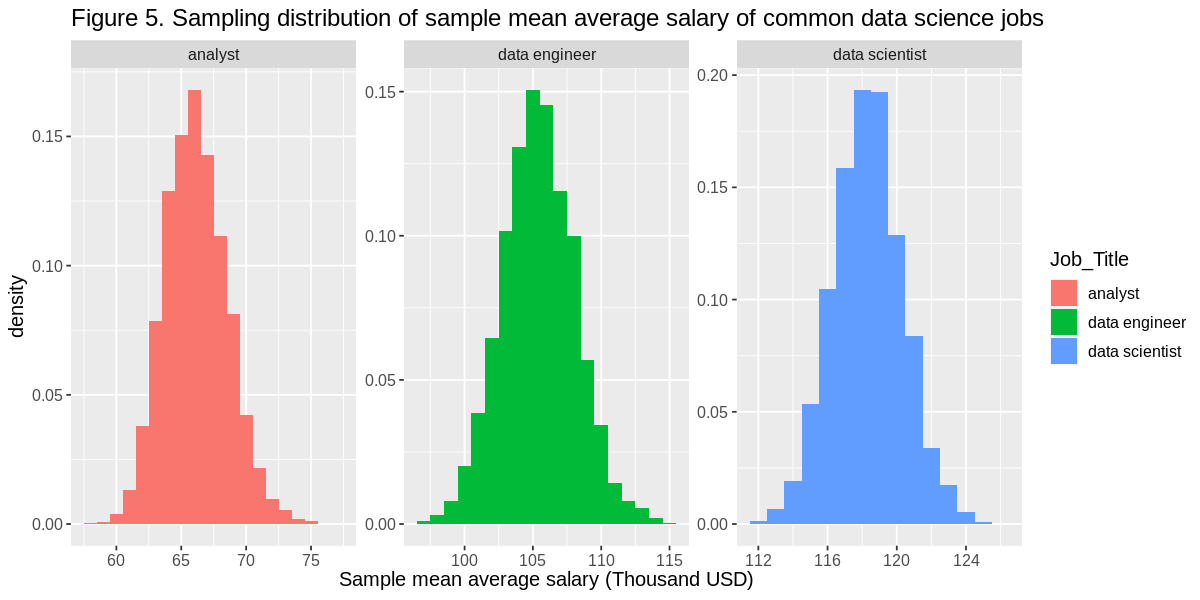

In [37]:
# combine all bootstrap samples into one big dataset
all_samples <- bind_rows(sampling_dist_scientist %>% mutate(Job_Title = "data scientist"),
                         sampling_dist_engineer %>% mutate(Job_Title = "data engineer"),
                         sampling_dist_analyst %>% mutate(Job_Title = "analyst"))
        

# plot the bootstrapped sampling distributions by job title
options(repr.plot.width=10, repr.plot.height=5)
sampling_dist_plots <- all_samples %>%
    group_by(Job_Title, replicate) %>%
    select(-replicate) %>%
    ggplot() +
    facet_wrap(~Job_Title, scale = "free") +
    geom_histogram(aes(x = sample_mean, y = ..density.., fill = Job_Title), binwidth = 1) +
    theme(text = element_text(size = 12)) +
    ggtitle("Figure 5. Sampling distribution of sample mean average salary of common data science jobs") +
    xlab("Sample mean average salary (Thousand USD)")
sampling_dist_plots

Warning message:
“Ignoring unknown parameters: linewidth”


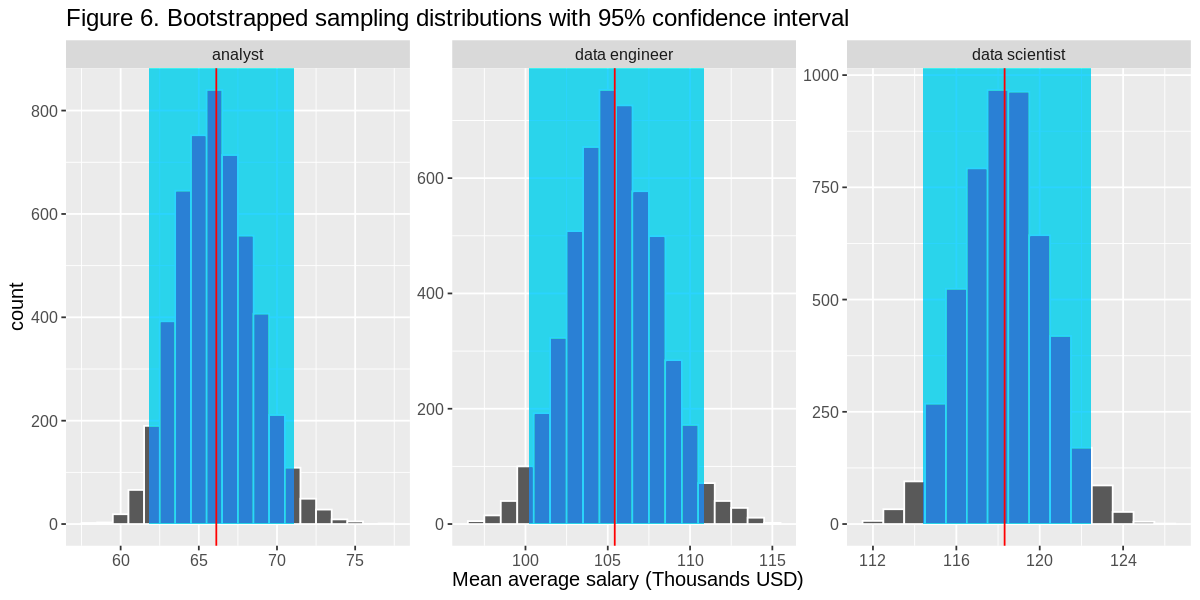

In [48]:
# plot 95% bootstrapped confidence intervals
options(repr.plot.width=10, repr.plot.height=5)
ci_df <- all_samples %>%
    group_by(Job_Title) %>%
    mutate(bootstrapped_mean = mean(sample_mean)) %>%
    mutate(bootstrapped_se = sd(sample_mean)) %>%
    mutate(lower_ci = quantile(sample_mean, 0.025)) %>%
    mutate(upper_ci = quantile(sample_mean, 0.975))

ci_plot <- ci_df %>%
    ggplot(aes(x = sample_mean, group = Job_Title)) +
    facet_wrap(~Job_Title, scale="free")  +
    geom_histogram(binwidth = 1, colour = "white") +
    geom_rect(aes(xmin = lower_ci, xmax = upper_ci, ymin = 0, ymax = Inf),
        fill="deepskyblue",
        alpha = 0.01) +
    geom_vline(aes(xintercept=bootstrapped_mean),
               linewidth = 2,
               colour = "red") +
    labs(title = "Figure 6. Bootstrapped sampling distributions with 95% confidence interval",
         x = "Mean average salary (Thousands USD)") +
    theme(text = element_text(size=12))
plot(ci_plot)

In [50]:
# create summary table for 95% bootstrapped confidence intervals

bootstrap_ci_summary_table <- ci_df %>%
    group_by(Job_Title) %>%
    filter(replicate==1) %>%
    select(-c('replicate', 'sample_mean')) %>%
    mutate(bootstrapped_mean = round(bootstrapped_mean, 4)) %>%
    mutate(bootstrapped_se = round(bootstrapped_se, 4)) %>%
    mutate(lower_ci = round(lower_ci, 4)) %>%
    mutate(upper_ci = round(upper_ci, 4))

##### Table 10. 95% bootstrapped confidence intervals for mean average salary of various data science job titles

In [51]:
bootstrap_ci_summary_table

Job_Title      bootstrapped_mean bootstrapped_se lower_ci upper_ci
1 data scientist 118.3155          2.0253          114.4167 122.4459
2 data engineer  105.4237          2.6848          100.2058 110.8616
3 analyst         66.1191          2.4055           61.8158  71.1188

From the bootstrapped results, we were 95% confident that the mean average salary (in thousand USD) for data scientist job titles is within the interval (114.4167, 122.4459), the mean average salary (in thousand USD) for data engineer job titles is in the interval (100.2058, 110.8616), and the mean average salary (in thousand USD) for (data) analyst job titles is in the interval (61.8158, 71.1188) (Table 10.).

In [58]:
# create summary table of all CIs
all_ci_summary_table <- tibble(Job_Title = c("data_scientist", "data_engineer", "analyst"),
                               sample_mean = c(clt_ci_summary_table$sample_mean[1],
                                               clt_ci_summary_table$sample_mean[2],
                                               clt_ci_summary_table$sample_mean[3]),
                               standard_error = c(clt_ci_summary_table$standard_error[1],
                                                  clt_ci_summary_table$standard_error[2],
                                                  clt_ci_summary_table$standard_error[3]),
                               clt_lower_ci = c(clt_ci_summary_table$lower_ci[1], 
                                                clt_ci_summary_table$lower_ci[2], 
                                                clt_ci_summary_table$lower_ci[3]),
                               clt_upper_ci = c(clt_ci_summary_table$upper_ci[1],
                                                clt_ci_summary_table$upper_ci[2],
                                                clt_ci_summary_table$upper_ci[3]),
                               bootstrapped_mean = c(bootstrap_ci_summary_table$bootstrapped_mean[1],
                                                     bootstrap_ci_summary_table$bootstrapped_mean[2],
                                                     bootstrap_ci_summary_table$bootstrapped_mean[3]),
                               bootstrapped_standard_error = c(bootstrap_ci_summary_table$bootstrapped_se[1],
                                                               bootstrap_ci_summary_table$bootstrapped_se[2],
                                                               bootstrap_ci_summary_table$bootstrapped_se[3]),
                               bootstrapped_lower_ci = c(bootstrap_ci_summary_table$lower_ci[1],
                                                         bootstrap_ci_summary_table$lower_ci[2],
                                                         bootstrap_ci_summary_table$lower_ci[3]),
                               bootstrapped_upper_ci = c(bootstrap_ci_summary_table$upper_ci[1],
                                                         bootstrap_ci_summary_table$upper_ci[2],
                                                         bootstrap_ci_summary_table$upper_ci[3]))

##### Table 11. Summary table of all 95% confidence intervals

In [59]:
all_ci_summary_table

Job_Title      sample_mean standard_error clt_lower_ci clt_upper_ci
1 data_scientist 118.2939    2.0272         114.3208     122.2671    
2 data_engineer  105.4034    2.6771         100.1563     110.6505    
3 analyst         66.1139    2.4205          61.3698      70.8579    
  bootstrapped_mean bootstrapped_standard_error bootstrapped_lower_ci
1 118.3155          2.0253                      114.4167             
2 105.4237          2.6848                      100.2058             
3  66.1191          2.4055                       61.8158             
  bootstrapped_upper_ci
1 122.4459             
2 110.8616             
3  71.1188

Comparing the confidence intervals made form Central Limit Theorem approximation and bootstrapping, we found that they were very similar (Table 11). In order to select only one interval for each job title, the one with the larger standard error was chosen to be more conservative despite the large sample sizes (Table 1). Therefore, we were 95% confident that the mean average salaries (thousand USD) for the job titles data scientist, data engineer and (data) analyst are captured by the intervals (114.3208, 122.2671), (100.2058, 110.8616), and (61.3698, 70.8579), respectively.

## Summary of Results

In order to examine the possible existence of a disparity between the average salary of different data science job titles, we carried out various tests in order to test our hypothesis, in which $H_0$ states that the mean average salary between the three job titles of interest (data science, data engineer and analyst) are the same, and $H_A$ states that the mean average salary of at least one group is different from the rest.

First, results from Shapiro Wilk test at 5% significance level show that all 3 sample distributions, which implies the population distributions as well, deviated from a Normal distributions (Table 2). However, due to the fact that ANOVA is  robust to small deivations from Normality, espcially when sample sizes are large, (Whitlock & Schluter, 2015), combining this with the observations that all 3 sample distributions showed some not very strong right skew (Fig. 3, 4), and that they all had large sample sizes (Table 1.), we declared the Normality condition for ANOVA to be met.

Next, results from F-tests for all 3 pairs of group conducted at the adjusted significant level of $\frac{5\%}{3} = 1.67\%$ suggest that the average salary variance of data scientist is different compared to data engineers and analyst group, while the average salary variance is suggested to be the same between data engineers and analysts (Table 6). With the data scientist group having a different variance compared to the other two groups, it was possible that the assumption of equal variance of ANOVA wass violated. However, ANOVA should be robust to this deviation from equal variance as the largest group standard deviation (data scientist, 35.86) was less than 2 times the smallest group standard deviation (analyst, 24.33), we continued with using ANOVA with care (Mindrila & Balentyne, n.d.; The Pennsylvania State University, n.d.; worksheet_11, 2023), keeping in mind of this possible violation.

Then, One-Way ANOVA was done in regards to the mean average salary of each group. $H_0$ was rejected at 5% signifiance level (Table 7), and as a consequence, at least one of the group's mean average salary is significantly different from the other groups. Therefore, in order to investigate which group's mean salary is significantly different, we proceeded with Tukey-Kramer test.

The pairwise Tukey-Kramer test was performed at the adjusted significant level of $\frac{5\%}{3} = 1.67\%$. Results showed that all three job titles have significantly different mean average salaries as their p-values were significantly lower than $1.67\%$ (Table 8). This suggests that different job titles have different mean average salary.

After that, Central Limit Theorem was used to approximate 95% confidence intervals for each job title's mean average salary (Table 9), and bootstrapping of 5000 replicates for each job title was done in order to estimate a more precise $95\%$ confidence interval for their respective mean average salary (Table 10). Both versions were very similar, and we ended up choosing the one with higher standard error to be more conservative. This led to our conclusion that with 95% confidence, the true mean average salary (in thousand USD) for data scientists is in the interval (114.3208, 122.2671), the true mean average salary for data engineers is in the interval (100.2058, 110.8616) and finally the true mean average salary is in the interval (61.3698, 70.8579) (Table 11).

## Comparison with Expectations

At an initial glance of the data, we only expected data scientist - data analyst and data engineer - data analyst pairings to have statistically significant differences in their mean average salaries (Fig.4). However, our findings also show that the pair data scientist - data engineer also have statistically significant results as well (Table 8). In the preliminary analysis, the differences (Table 1) were not large enough to make us confident in predicting that there would probably be a significant difference in salary means, but after conducting the ANOVA and then the Tukey-Kramer test, we identified that the differences are also, in fact, significant (Table 7, 8). Nonetheless, we should still highlight the fact that the Normality and homogeneity of variance conditions were not exactly met based on the results of Shapiro Wilk tests and F-tests (Table 2, 3, 4, 5, 6). They were assumed to be met due to ANOVA's robustness to slight deivations from them given that some other conditions were met (Whitlock & Schluter, 2015; Mindrila & Balentyne, n.d.; The Pennsylvania State University, n.d.; worksheet_11, 2023). Therefore, if the exact conditions were met, perhaps the final results and conclusions could have been different.


## NOTE: need to edit the following

Similar to the first point of comparison, the bootstrapped 95% confidence intervals of the data scientist and data engineer mean salaries don't have any overlap whatsoever. This doubles down on the differences shared between the two groups and the significance of the results found.

While we did not make any formal predictions on the variance of different job titles, we found that there were differing variances among the analyzed job titles, with only data engineers and data analysts having insignificant differences. 

## Significance & Impact

Our findings provide key insights for all people looking for jobs in the data science industry, current workers, and employers of the data science industry. Our report implies that certain data science job titles yield a higher salary than other job titles with the assumption that tasks performed are very similar in the industry. Specifically, we see that the job name "data scientist" fetches a higher average salary across the board compared to "data engineer" or more drastically to (data) "analyst". This disparity brings up ethical questions regarding the misrepresentation of jobs and tasks by employers for lower salaries, the functionalities and effects of job titles in the data science industry, as well as the true similarities and differences between the categories. If the change of a single word in a job title would statistically have increased its salary by over 10% or more, one would undoubtedly question the efficacy of the role structure in the industry. For people looking to get into the data science industry, this report suggests that it may be advantageous to seek positions that have similar roles, but carry "high-salary" job titles. While for those that already work in the industry, it can help to interpret whether or not their work is underpaid or overpaid, simply due to a word in their job title. Finally through the perspective of employers and companies, this insight could help estimate previous salaries of prospective employees for job offers as well as define salary ranges for existing positions. No matter how it is used, this report provides valuable insight and an objective perspective into the structure of today's data science industry.

## Future Directions:

Since this project only focused on the comparison of different job titles' mean salaries, there were several factors that were not considered, but could be potentially insightful for future analysis:
- **Location**: The dataset was taken online from US participants. We could inverstigate if the results found in this report is also consistent for **every state**, **every region** or perhaps with more data to **other countries**.
- **Company Size**: One factor that was not interpreted was the size of the companies (in terms of revenue and number of employees as some examples) where the reported jobs came from. This factor in combination with our results could provide new perspectives into companies' hiring practices and strategies in the data science industry.
- **Skills for Each Job Title:** As found in our report, certain job titles statistically saw a higher average salary. A potential future analysis could be looking at the relation of specific "skill-keywords" found in each job position/posting with its average annual salary.
- **Gender**: There has long been research on the disparity of salary among people of different genders (*need reference*). Crossing these results with these findings could provide valuable insight on the equality and equity found in the data science industry.


## References

- Smith, Brien N., et al. “What Is in a Name: The Impact of Job Titles on Job Evaluation Results.” Journal of Business and Psychology, vol. 3, no. 3, 1989, pp. 341–51. JSTOR, http://www.jstor.org/stable/25092192. Accessed 9 Mar. 2023.
- Gerhart, B. (1990). Gender Differences in Current and Starting Salaries: The Role of Performance, College Major, and Job Title. ILR Review, 43(4), 418–433. https://doi.org/10.1177/001979399004300406
- *worksheet_11*. (2023, March 27). Canvas. Retrieved April 9, 2023, from https://canvas.ubc.ca/courses/110110/assignments/1445853?module_item_id=5256779.
- Mindrila, D., and Balentyne, P. (n.d.). *One-Way Analysis of Variance: Comparing Several Means* [Lecture notes]. University of West Georgia. https://www.westga.edu/academics/research/vrc/assets/docs/OneWayANOVA_LectureNotes.pdf.
- The Pennsylvania State University. (n.d.). *STAT 500 10.2.1 - ANOVA Assumptions*. PennState Eberly College of Science. https://online.stat.psu.edu/stat500/lesson/10/10.2/10.2.1.
- Whitlock, M., & Schluter, D. (2015). *The Analysis of Biological Data* (Second ed.). Roberts and Company Publishers.